In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
from Utils.Models import *
from Utils.EABCSMC import *
from Utils.Preconditioning import * 

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
italy = pd.read_csv('Data/Sird_bigdata.csv')
italy.fillna(0, inplace = True)

Precond = Preconditioner(SIRD_reduced_30_new)

Precond.preprocess_data(data=italy, start=0, eff=30, ext=150, SIRD=True)

In [3]:
popt, pcov = Precond.fit(p0 = (0.1, 0.1, 10, 0.1), bounds=([0, 0, 0, 0], [3, 7, 200, 3]))

In [4]:
lambda_ranges = [npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 10, high = 20)]
prior_means =  np.array([ 0.28802481,  0.03922435,  10,  0.06892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 30, 
                         lambda_ranges = lambda_ranges, prior_means = prior_means, n_jobs = 4)

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

Borders estimation start...


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Acceptance rate:  0.0028
Borders estimation completed, starting preprocessing...
Borders: [0.3737985266883166, 0.010185274636022638, 10.439202942633369, 0.09948827778934546]


  0%|▏                                                                             | 32/15000 [00:00<01:13, 203.23it/s]

Acceptance rate:  0.0019333333333333333
Preprocessing completed, starting ABC-SMC


  0%|                                                                              | 16/15000 [00:00<01:34, 159.33it/s]

Acceptance rate:  0.0162
ABS-SMC round :  1


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:19<00:00, 187.61it/s]


Acceptance rate:  0.0522


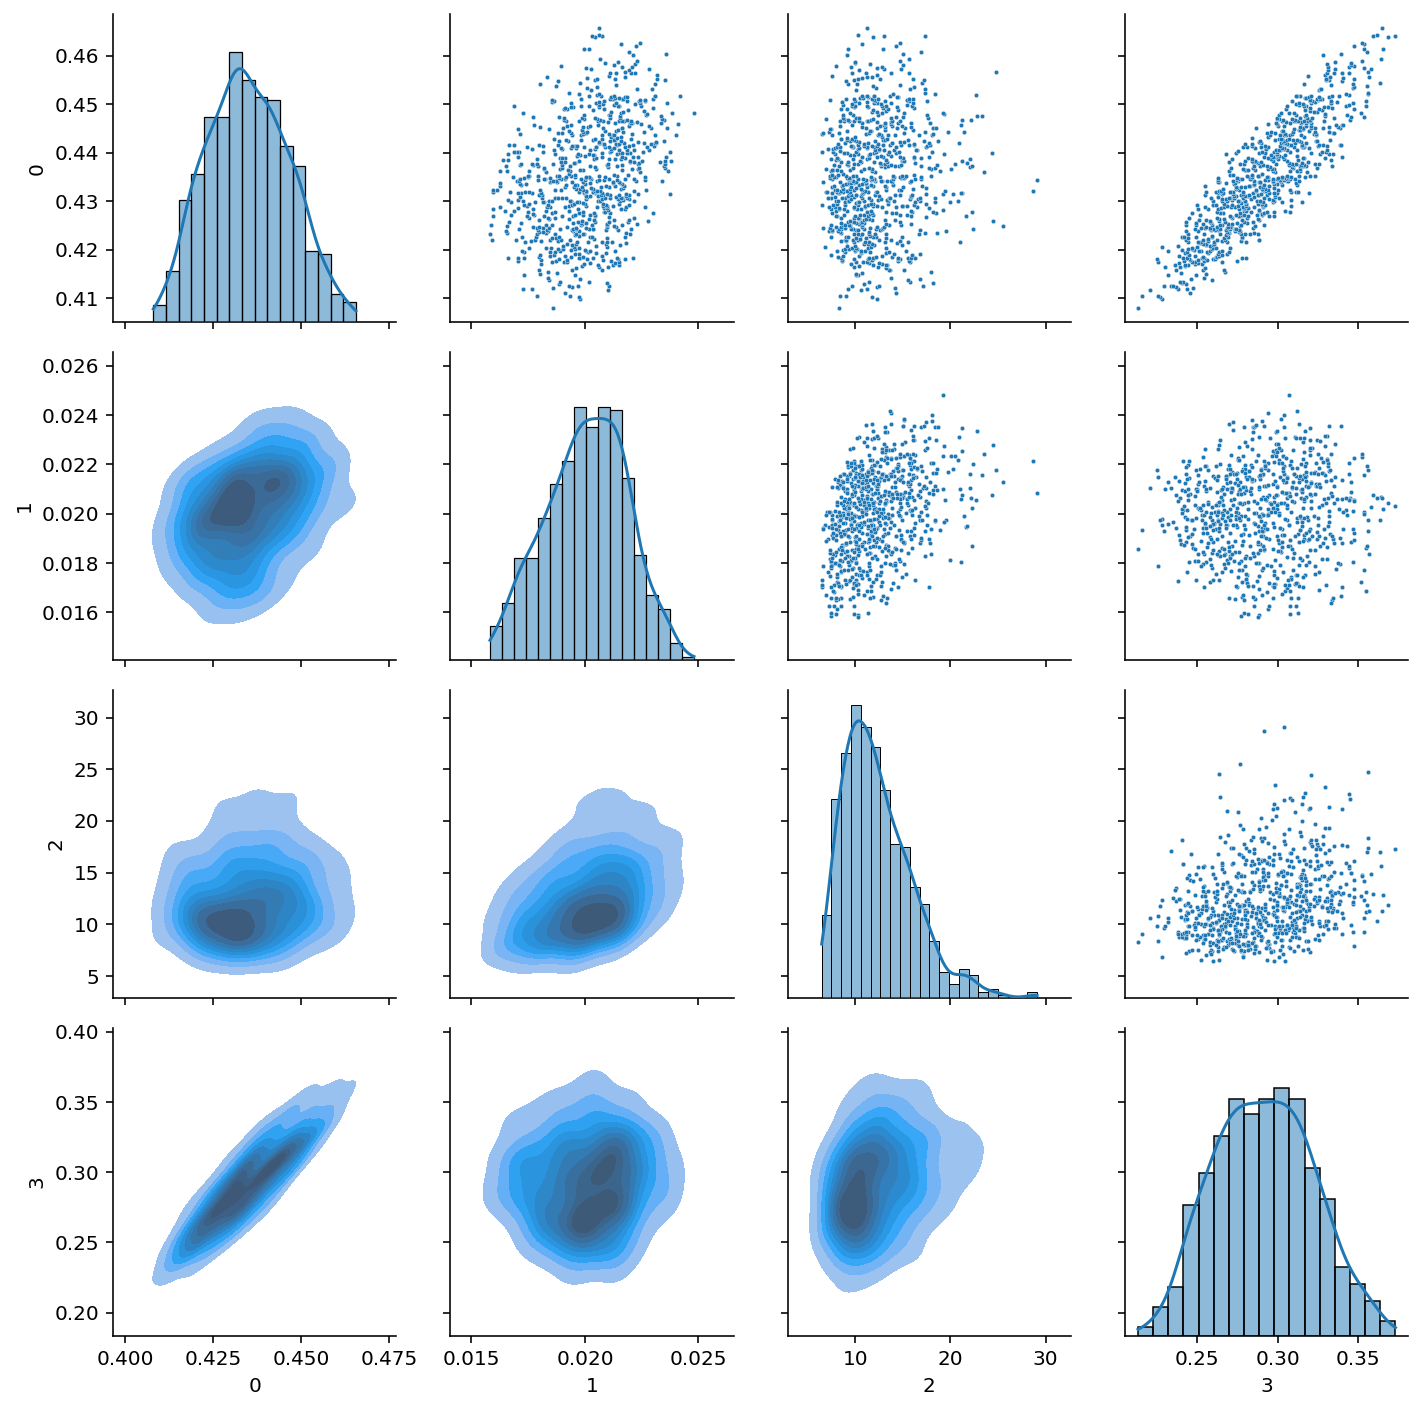

In [16]:
Sampler.fit(niters=3000, eps_schedule=[1, 1/2, 1/5, 1/10], niters_schedule=[10, 5, 5, 5])
Sampler.pairplot()

In [17]:
parameters = Sampler.parameters

100%|███████████████████████████████████████████████████████████████████████████████| 783/783 [00:06<00:00, 130.32it/s]


90351.7724723367 163956.18777599567
50 61
55


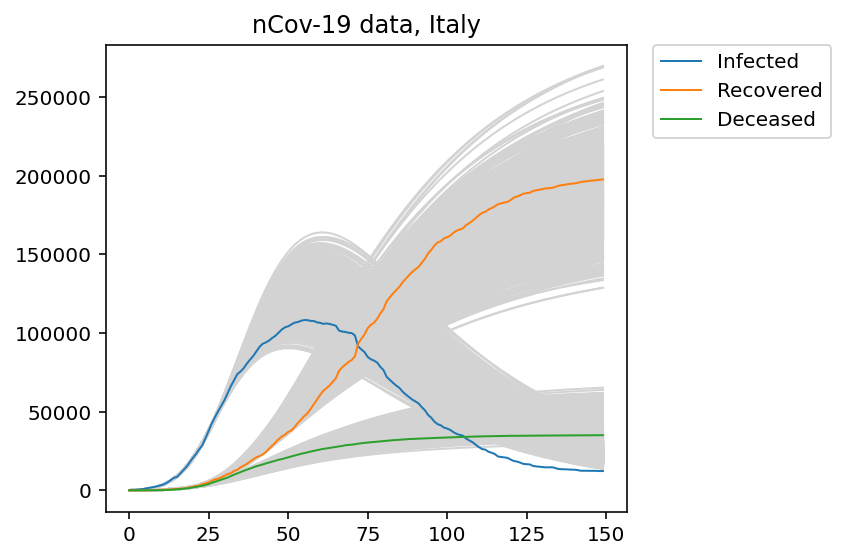

In [18]:
# magari anche questo lo metto dentro all'abc sampler

peak = []
day_peak = []

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIRD_reduced_30_new, [221,1,7], np.arange(150), args=tuple(parameters[j]))
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0]))
    
plot_traj_SIRD(Precond.extended_y)

print(min(peak), max(peak))
print(min(day_peak), max(day_peak))
print(np.argmax(Precond.extended_y[:,0]))

plt.show()